<a href="https://colab.research.google.com/github/tenvol/tsf00/blob/master/Copy_of_sparsity_and_l1_regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Copyright 2017 Google LLC.

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Sparsity and L1 Regularization

**Learning Objectives:**
  * Calculate the size of a model
  * Apply L1 regularization to reduce the size of a model by increasing sparsity

One way to reduce complexity is to use a regularization function that encourages weights to be exactly zero. For linear models such as regression, a zero weight is equivalent to not using the corresponding feature at all. In addition to avoiding overfitting, the resulting model will be more efficient.

L1 regularization is a good way to increase sparsity.



## Setup

Run the cells below to load the data and create feature definitions.

In [0]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))

In [2]:
np.random.permutation(np.linspace(1,100))

array([ 63.63265306,  43.42857143,  33.32653061,  95.95918367,
        73.73469388,  17.16326531,  11.10204082,   1.        ,
        93.93877551,  97.97959184,  27.26530612,  85.85714286,
        13.12244898,  45.44897959,  53.53061224,  15.14285714,
        77.7755102 , 100.        ,  71.71428571,  91.91836735,
        75.75510204,  29.28571429,  19.18367347,  35.34693878,
        87.87755102,  55.55102041,  57.57142857,  39.3877551 ,
        41.40816327,  61.6122449 ,   9.08163265,   5.04081633,
        67.67346939,  31.30612245,  47.46938776,   3.02040816,
        83.83673469,  69.69387755,  51.51020408,  21.20408163,
        49.48979592,  23.2244898 ,  65.65306122,   7.06122449,
        79.79591837,  25.24489796,  89.89795918,  37.36734694,
        59.59183673,  81.81632653])

In [3]:
np.linspace(1,100)

array([  1.        ,   3.02040816,   5.04081633,   7.06122449,
         9.08163265,  11.10204082,  13.12244898,  15.14285714,
        17.16326531,  19.18367347,  21.20408163,  23.2244898 ,
        25.24489796,  27.26530612,  29.28571429,  31.30612245,
        33.32653061,  35.34693878,  37.36734694,  39.3877551 ,
        41.40816327,  43.42857143,  45.44897959,  47.46938776,
        49.48979592,  51.51020408,  53.53061224,  55.55102041,
        57.57142857,  59.59183673,  61.6122449 ,  63.63265306,
        65.65306122,  67.67346939,  69.69387755,  71.71428571,
        73.73469388,  75.75510204,  77.7755102 ,  79.79591837,
        81.81632653,  83.83673469,  85.85714286,  87.87755102,
        89.89795918,  91.91836735,  93.93877551,  95.95918367,
        97.97959184, 100.        ])

In [0]:
def preprocess_features(california_housing_dataframe):
  """Prepares input features from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = california_housing_dataframe[
    ["latitude",
     "longitude",
     "housing_median_age",
     "total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"]]
  processed_features = selected_features.copy()
  # Create a synthetic feature.
  processed_features["rooms_per_person"] = (
    california_housing_dataframe["total_rooms"] /
    california_housing_dataframe["population"])
  return processed_features

def preprocess_targets(california_housing_dataframe):
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  # Create a boolean categorical feature representing whether the
  # median_house_value is above a set threshold.
  output_targets["median_house_value_is_high"] = (
    california_housing_dataframe["median_house_value"] > 265000).astype(float)
  return output_targets

In [5]:
california_housing_dataframe['median_house_value'] > 265000

5459     False
15144    False
7023      True
366       True
14345     True
         ...  
2110     False
12450     True
850      False
2555     False
570      False
Name: median_house_value, Length: 17000, dtype: bool

In [6]:
(california_housing_dataframe['median_house_value'] > 265000).astype(float)

5459    0.0
15144   0.0
7023    1.0
366     1.0
14345   1.0
         ..
2110    0.0
12450   1.0
850     0.0
2555    0.0
570     0.0
Name: median_house_value, Length: 17000, dtype: float64

In [7]:
(california_housing_dataframe['median_house_value'] > 265000)*1

5459     0
15144    0
7023     1
366      1
14345    1
        ..
2110     0
12450    1
850      0
2555     0
570      0
Name: median_house_value, Length: 17000, dtype: int64

In [8]:
# Choose the first 12000 (out of 17000) examples for training.
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

# Choose the last 5000 (out of 17000) examples for validation.
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

# Double-check that we've done the right thing.
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.6,2633.9,537.0,1420.0,498.4,3.9,2.0
std,2.1,2.0,12.6,2159.4,416.6,1094.4,378.9,1.9,1.2
min,32.5,-124.3,1.0,2.0,1.0,6.0,1.0,0.5,0.0
25%,33.9,-121.8,18.0,1461.0,295.0,786.0,281.0,2.6,1.5
50%,34.3,-118.5,29.0,2124.0,431.0,1163.0,407.0,3.5,1.9
75%,37.7,-118.0,37.0,3148.0,644.0,1714.0,601.0,4.8,2.3
max,42.0,-114.5,52.0,37937.0,5471.0,16122.0,5189.0,15.0,55.2


Validation examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.5,28.7,2667.0,545.3,1452.5,507.9,3.9,2.0
std,2.1,2.0,12.6,2228.5,433.1,1266.8,397.6,1.9,1.2
min,32.5,-124.3,1.0,15.0,3.0,3.0,3.0,0.5,0.1
25%,33.9,-121.8,18.0,1465.0,300.0,800.0,285.0,2.6,1.5
50%,34.2,-118.5,29.0,2138.0,441.0,1176.0,414.0,3.5,1.9
75%,37.7,-118.0,37.0,3157.0,659.2,1747.2,614.0,4.8,2.3
max,41.9,-114.3,52.0,32627.0,6445.0,35682.0,6082.0,15.0,41.3


Training targets summary:


,median_house_value_is_high
count,12000.0
mean,0.2
std,0.4
min,0.0
25%,0.0
50%,0.0
75%,0.2
max,1.0


Validation targets summary:


,median_house_value_is_high
count,5000.0
mean,0.2
std,0.4
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,1.0


In [9]:
training_examples.columns

Index([u'latitude', u'longitude', u'housing_median_age', u'total_rooms',
       u'total_bedrooms', u'population', u'households', u'median_income',
       u'rooms_per_person'],
      dtype='object')

In [10]:
training_examples.head(9)

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
5459,34.0,-118.2,37.0,690.0,261.0,952.0,255.0,1.6,0.7
15144,37.8,-122.3,29.0,335.0,107.0,202.0,91.0,2.0,1.7
7023,33.8,-118.3,30.0,1773.0,356.0,905.0,352.0,4.3,2.0
366,32.7,-116.9,8.0,4630.0,624.0,2048.0,575.0,6.5,2.3
14345,37.4,-122.1,37.0,2511.0,354.0,945.0,348.0,8.4,2.7
13974,37.9,-122.0,20.0,5467.0,1044.0,2310.0,963.0,5.7,2.4
7161,33.4,-118.3,27.0,1675.0,521.0,744.0,331.0,2.2,2.3
2352,33.9,-117.5,26.0,2970.0,576.0,2156.0,558.0,4.0,1.4
7153,33.8,-118.3,35.0,2924.0,658.0,1675.0,602.0,3.8,1.7


In [11]:
dict(training_examples).items()[:9]

[('total_bedrooms', 5459     261.0
  15144    107.0
  7023     356.0
  366      624.0
  14345    354.0
           ...  
  10249    293.0
  1540     533.0
  2622     501.0
  3858     496.0
  10284   1358.0
  Name: total_bedrooms, Length: 12000, dtype: float64),
 ('median_income', 5459    1.6
  15144   2.0
  7023    4.3
  366     6.5
  14345   8.4
           ..
  10249   2.7
  1540    4.2
  2622    6.7
  3858    5.1
  10284   2.1
  Name: median_income, Length: 12000, dtype: float64),
 ('households', 5459    255.0
  15144    91.0
  7023    352.0
  366     575.0
  14345   348.0
           ... 
  10249   226.0
  1540    513.0
  2622    520.0
  3858    496.0
  10284   189.0
  Name: households, Length: 12000, dtype: float64),
 ('housing_median_age', 5459    37.0
  15144   29.0
  7023    30.0
  366      8.0
  14345   37.0
          ... 
  10249   25.0
  1540    28.0
  2622    17.0
  3858    28.0
  10284   26.0
  Name: housing_median_age, Length: 12000, dtype: float64),
 ('longitude', 5459    -

In [12]:
for k,v in dict(training_examples).items()[-3:]:
    print('key is {}, value is {}'.format(k,v))


key is rooms_per_person, value is 5459     0.7
15144    1.7
7023     2.0
366      2.3
14345    2.7
        ... 
10249    2.4
1540     2.4
2622     2.0
3858     2.2
10284   16.8
Name: rooms_per_person, Length: 12000, dtype: float64
key is latitude, value is 5459    34.0
15144   37.8
7023    33.8
366     32.7
14345   37.4
        ... 
10249   38.9
1540    32.8
2622    33.6
3858    33.9
10284   38.2
Name: latitude, Length: 12000, dtype: float64
key is population, value is 5459     952.0
15144    202.0
7023     905.0
366     2048.0
14345    945.0
         ...  
10249    534.0
1540    1334.0
2622    1555.0
3858    1287.0
10284    416.0
Name: population, Length: 12000, dtype: float64


In [13]:
for k,v in dict(training_examples).items()[-3:]:
    print('key:np.array(value) is {}'.format({k:np.array(v)}))
    fea = {k:np.array(v)}
    print(fea)

key:np.array(value) is {'rooms_per_person': array([ 0.72478992,  1.65841584,  1.95911602, ...,  2.04051447,
        2.21522922, 16.83894231])}
{'rooms_per_person': array([ 0.72478992,  1.65841584,  1.95911602, ...,  2.04051447,
        2.21522922, 16.83894231])}
key:np.array(value) is {'latitude': array([34.01, 37.81, 33.81, ..., 33.64, 33.94, 38.19])}
{'latitude': array([34.01, 37.81, 33.81, ..., 33.64, 33.94, 38.19])}
key:np.array(value) is {'population': array([ 952.,  202.,  905., ..., 1555., 1287.,  416.])}
{'population': array([ 952.,  202.,  905., ..., 1555., 1287.,  416.])}


In [14]:
validation_examples.quantile([0.25, 0.5,1])

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
0.2,33.9,-121.8,18.0,1465.0,300.0,800.0,285.0,2.6,1.5
0.5,34.2,-118.5,29.0,2138.0,441.0,1176.0,414.0,3.5,1.9
1.0,41.9,-114.3,52.0,32627.0,6445.0,35682.0,6082.0,15.0,41.3


In [15]:
quan = validation_examples.quantile([0.25, 0.5,1])
for key in quan.keys():
  print(quan[key])

0.2   33.9
0.5   34.2
1.0   41.9
Name: latitude, dtype: float64
0.2   -121.8
0.5   -118.5
1.0   -114.3
Name: longitude, dtype: float64
0.2   18.0
0.5   29.0
1.0   52.0
Name: housing_median_age, dtype: float64
0.2    1465.0
0.5    2138.0
1.0   32627.0
Name: total_rooms, dtype: float64
0.2    300.0
0.5    441.0
1.0   6445.0
Name: total_bedrooms, dtype: float64
0.2     800.0
0.5    1176.0
1.0   35682.0
Name: population, dtype: float64
0.2    285.0
0.5    414.0
1.0   6082.0
Name: households, dtype: float64
0.2    2.6
0.5    3.5
1.0   15.0
Name: median_income, dtype: float64
0.2    1.5
0.5    1.9
1.0   41.3
Name: rooms_per_person, dtype: float64


In [16]:
validation_examples.describe()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.5,28.7,2667.0,545.3,1452.5,507.9,3.9,2.0
std,2.1,2.0,12.6,2228.5,433.1,1266.8,397.6,1.9,1.2
min,32.5,-124.3,1.0,15.0,3.0,3.0,3.0,0.5,0.1
25%,33.9,-121.8,18.0,1465.0,300.0,800.0,285.0,2.6,1.5
50%,34.2,-118.5,29.0,2138.0,441.0,1176.0,414.0,3.5,1.9
75%,37.7,-118.0,37.0,3157.0,659.2,1747.2,614.0,4.8,2.3
max,41.9,-114.3,52.0,32627.0,6445.0,35682.0,6082.0,15.0,41.3


In [0]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
  
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                            
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [0]:
def get_quantile_based_buckets(feature_values, num_buckets):
  quantiles = feature_values.quantile(
    [(i+1.)/(num_buckets + 1.) for i in range(num_buckets)])
  return [quantiles[q] for q in quantiles.keys()]

In [0]:
def construct_feature_columns():
  """Construct the TensorFlow Feature Columns.

  Returns:
    A set of feature columns
  """

  bucketized_households = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column("households"),
    boundaries=get_quantile_based_buckets(training_examples["households"], 10))
  bucketized_longitude = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column("longitude"),
    boundaries=get_quantile_based_buckets(training_examples["longitude"], 50))
  bucketized_latitude = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column("latitude"),
    boundaries=get_quantile_based_buckets(training_examples["latitude"], 50))
  bucketized_housing_median_age = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column("housing_median_age"),
    boundaries=get_quantile_based_buckets(
      training_examples["housing_median_age"], 10))
  bucketized_total_rooms = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column("total_rooms"),
    boundaries=get_quantile_based_buckets(training_examples["total_rooms"], 10))
  bucketized_total_bedrooms = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column("total_bedrooms"),
    boundaries=get_quantile_based_buckets(training_examples["total_bedrooms"], 10))
  bucketized_population = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column("population"),
    boundaries=get_quantile_based_buckets(training_examples["population"], 10))
  bucketized_median_income = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column("median_income"),
    boundaries=get_quantile_based_buckets(training_examples["median_income"], 10))
  bucketized_rooms_per_person = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column("rooms_per_person"),
    boundaries=get_quantile_based_buckets(
      training_examples["rooms_per_person"], 10))

  long_x_lat = tf.feature_column.crossed_column(
    set([bucketized_longitude, bucketized_latitude]), hash_bucket_size=1000)

  feature_columns = set([
    long_x_lat,
    bucketized_longitude,
    bucketized_latitude,
    bucketized_housing_median_age,
    bucketized_total_rooms,
    bucketized_total_bedrooms,
    bucketized_population,
    bucketized_households,
    bucketized_median_income,
    bucketized_rooms_per_person])
  
  return feature_columns

In [0]:
bucket_feature_col = construct_feature_columns()

In [21]:
len(bucket_feature_col)

10

In [22]:
bucket_feature_col

{_CrossedColumn(keys=(_BucketizedColumn(source_column=_NumericColumn(key='latitude', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(32.73, 32.79, 32.95, 33.22, 33.62, 33.70647058823529, 33.75, 33.79, 33.82, 33.86, 33.89, 33.91, 33.94, 33.97, 33.99, 34.02, 34.04, 34.05, 34.07, 34.09, 34.11, 34.14, 34.16, 34.19, 34.23, 34.29, 34.56, 35.28, 35.94, 36.55, 36.77, 36.97, 37.28, 37.34, 37.42, 37.54, 37.65, 37.71, 37.76, 37.79, 37.83, 37.93, 37.98, 38.09, 38.33, 38.5, 38.61, 38.76, 39.18, 39.999019607843145)), _BucketizedColumn(source_column=_NumericColumn(key='longitude', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(-122.73, -122.48999999999998, -122.44, -122.37, -122.28, -122.23999999999998, -122.18, -122.1, -122.04000000000002, -121.99, -121.93, -121.86, -121.76999999999998, -121.55, -121.41, -121.29999999999998, -121.21333333333334, -120.98, -120.64, -120.19509803921568, -119.8, -119.63, -119.22, -118.99, -118.59, -1

In [23]:
for s in bucket_feature_col:
  print(s.index)
  print(s.name)

<built-in method index of _BucketizedColumn object at 0x7fa1005fce68>
rooms_per_person_bucketized
<built-in method index of _BucketizedColumn object at 0x7fa1005fcc00>
longitude_bucketized
<built-in method index of _BucketizedColumn object at 0x7fa1005fcd08>
latitude_bucketized
<built-in method index of _BucketizedColumn object at 0x7fa1005fce10>
median_income_bucketized
<built-in method index of _BucketizedColumn object at 0x7fa1005fcc58>
total_rooms_bucketized
<built-in method index of _BucketizedColumn object at 0x7fa1005fcd60>
total_bedrooms_bucketized
<built-in method index of _CrossedColumn object at 0x7fa100593050>
latitude_bucketized_X_longitude_bucketized
<built-in method index of _BucketizedColumn object at 0x7fa1005fcba8>
housing_median_age_bucketized
<built-in method index of _BucketizedColumn object at 0x7fa1005fccb0>
households_bucketized
<built-in method index of _BucketizedColumn object at 0x7fa1005fcdb8>
population_bucketized


## Calculate the Model Size

To calculate the model size, we simply count the number of parameters that are non-zero. We provide a helper function below to do that. The function uses intimate knowledge of the Estimators API - don't worry about understanding how it works.

In [0]:
def model_size(estimator):
  variables = estimator.get_variable_names()
  size = 0
  for variable in variables:
    if not any(x in variable 
               for x in ['global_step',
                         'centered_bias_weight',
                         'bias_weight',
                         'Ftrl']
              ):
      size += np.count_nonzero(estimator.get_variable_value(variable))
  return size

## Reduce the Model Size

Your team needs to build a highly accurate Logistic Regression model on the *SmartRing*, a ring that is so smart it can sense the demographics of a city block ('median_income', 'avg_rooms', 'households', ..., etc.) and tell you whether the given city block is high cost city block or not.

Since the SmartRing is small, the engineering team has determined that it can only handle a model that has **no more than 600 parameters**. On the other hand, the product management team has determined that the model is not launchable unless the **LogLoss is less than 0.35** on the holdout test set.

Can you use your secret weapon—L1 regularization—to tune the model to satisfy both the size and accuracy constraints?

### Task 1: Find a good regularization coefficient.

**Find an L1 regularization strength parameter which satisfies both constraints — model size is less than 600 and log-loss is less than 0.35 on validation set.**

The following code will help you get started. There are many ways to apply regularization to your model. Here, we chose to do it using `FtrlOptimizer`, which is designed to give better results with L1 regularization than standard gradient descent.

Again, the model will train on the entire data set, so expect it to run slower than normal.

In [0]:
def train_linear_classifier_model(
    learning_rate,
    regularization_strength,
    steps,
    batch_size,
    feature_columns,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    regularization_strength: A `float` that indicates the strength of the L1
       regularization. A value of `0.0` means no regularization.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    feature_columns: A `set` specifying the input feature columns to use.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearClassifier` object trained on the training data.
  """

  periods = 7
  steps_per_period = steps / periods

  # Create a linear classifier object.
  my_optimizer = tf.train.FtrlOptimizer(learning_rate=learning_rate, l1_regularization_strength=regularization_strength)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_classifier = tf.estimator.LinearClassifier(
      feature_columns=feature_columns,
      optimizer=my_optimizer
  )
  
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["median_house_value_is_high"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["median_house_value_is_high"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["median_house_value_is_high"], 
                                                    num_epochs=1, 
                                                    shuffle=False)
  
  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("LogLoss (on validation data):")
  training_log_losses = []
  validation_log_losses = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_classifier.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    training_probabilities = linear_classifier.predict(input_fn=predict_training_input_fn)
    training_probabilities = np.array([item['probabilities'] for item in training_probabilities])
    
    validation_probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)
    validation_probabilities = np.array([item['probabilities'] for item in validation_probabilities])
    
    # Compute training and validation loss.
    training_log_loss = metrics.log_loss(training_targets, training_probabilities)
    validation_log_loss = metrics.log_loss(validation_targets, validation_probabilities)
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, validation_log_loss))
    # Add the loss metrics from this period to our list.
    training_log_losses.append(training_log_loss)
    validation_log_losses.append(validation_log_loss)
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.ylabel("LogLoss")
  plt.xlabel("Periods")
  plt.title("LogLoss vs. Periods")
  plt.tight_layout()
  plt.plot(training_log_losses, label="training")
  plt.plot(validation_log_losses, label="validation")
  plt.legend()

  return linear_classifier

Training model...
LogLoss (on validation data):
  period 00 : 0.35
  period 01 : 0.30
  period 02 : 0.28
  period 03 : 0.27
  period 04 : 0.26
  period 05 : 0.26
  period 06 : 0.26
Model training finished.
Model size: 415


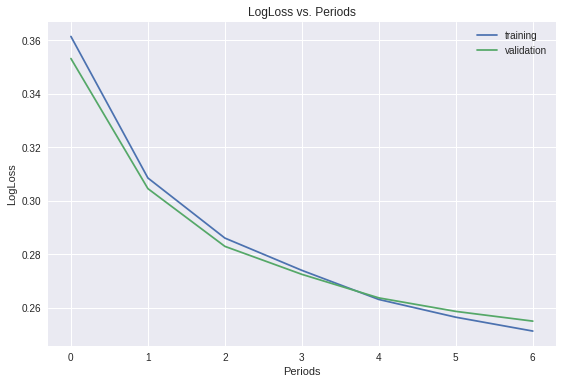

In [30]:
linear_classifier = train_linear_classifier_model(
    learning_rate=0.1,
    # TWEAK THE REGULARIZATION VALUE BELOW
    regularization_strength=2.0,
    steps=300,
    batch_size=100,
    feature_columns=construct_feature_columns(),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)
print("Model size:", model_size(linear_classifier))

### Solution

Click below to see a possible solution.

A regularization strength of 0.1 should be sufficient. Note that there is a compromise to be struck:
stronger regularization gives us smaller models, but can affect the classification loss.

Training model...
LogLoss (on validation data):
  period 00 : 0.31
  period 01 : 0.28
  period 02 : 0.27
  period 03 : 0.26
  period 04 : 0.25
  period 05 : 0.25
  period 06 : 0.25
Model training finished.
Model size: 759


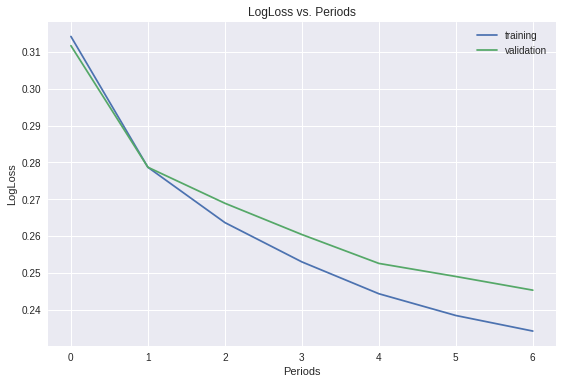

In [31]:
linear_classifier = train_linear_classifier_model(
    learning_rate=0.1,
    regularization_strength=0.1,
    steps=300,
    batch_size=100,
    feature_columns=construct_feature_columns(),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)
print("Model size:", model_size(linear_classifier))